## geo_mozambique_1

In [24]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

import osmnx as ox

from bs4 import BeautifulSoup

import fiona

import gdal

import pyproj

import rasterio as rio
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import cartopy as cp
from shapely.geometry import mapping
from pathlib import Path

import requests
import urllib
import urllib.parse

import os
import pathlib
import subprocess

import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv

from ast import literal_eval

import shapely

from ipyleaflet import (Map, basemaps, basemap_to_tiles, 
                       TileLayer, SplitMapControl, Polygon)

%matplotlib inline

In [25]:
np.random.seed(3)

### Data understanding

#### Acquire vector files of country boundaries

In [26]:
# download 10m country boundary vector files from Natural Earth
subprocess.call(['wget',
                 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip', #noqa
                 '-P',
                 '~/Documents/projects_code/geo_mozambique/data/shapes/'])

# unzip downloaded files
subprocess.call(['unzip',
                 '~/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.zip', #noqa
                 '-d', 
                 '~/Documents/projects_code/geo_mozambique/data/shapes/'])

# specify directory containing shapefiles
shapes = '/Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.shp' #noqa

# create geodataframe, a pandas-like data structure containing geoseries
gdf = gpd.read_file(shapes)

# inspect coordinate reference system (CRS). EPSG code 4326, which is WGS84
gdf.crs

{'init': 'epsg:4326'}

In [27]:
# subset shape file to only include country borders of Mozambique
gdf_mozambique = gdf[gdf['ADMIN']=='Mozambique']

# inspect geometry
gdf_mozambique.geometry

122    (POLYGON ((32.11388431800009 -26.8400143429999...
Name: geometry, dtype: object

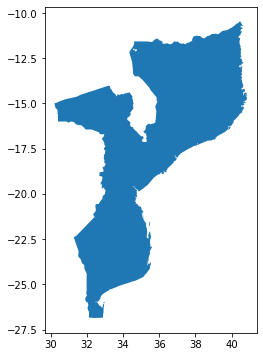

In [28]:
# plot Mozambique polygon 
fig, ax = plt.subplots(figsize=(6,6))

ax.set_aspect('equal') # set aspect to equal when plotting directly with plt
_ = gdf_mozambique.plot(ax=ax, legend=True)

#### Acquire high-resolution raster files from Maxar's Digital Globe Open Data

In [29]:
# pre-inspect metadata of vector files
filepath = 'https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif' #noqa
with rio.open(filepath) as src:
    print(src.profile)

# ('driver': 'GTiff') = object is a Geotiff
# Digital Global open data files are Cloud Optimized Geotif (COG), which is a 
# regular GeoTIFF file for hosting on a HTTP file server, for cloud workflows,
# by leveraging client HTTP GET range requests to ask for relevant file parts

# ('dtype': 'uint8') = image values are unsigned integer format
# ('nodata': 0.0) = nodata values are not assigned
# ('width': 19584, 'height': 19584) = img has dimensions of 19584 x 19584 
# ('count': 3) = is a single band
# ('crs': CRS.from_epsg(4326) = is in UTM coordinates
# (Affine()) = has a simple affine transformation (Affine())
# ('tiled': False) = is not chunked into smaller arrays
# ('interleave': 'pixel') = interleave is pixel

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 19584, 'height': 19584, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.48787913602941e-06, 0.0, 33.3984375,
       0.0, -4.48787913602941e-06, -21.005859375), 'tiled': False, 'interleave': 'pixel'}


In [30]:
# build virtual dataset (VRT) for mosaic from Digital Globe files 
subprocess.call(['gdalbuildvrt', 'test.vrt', '/vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif']) #noqa

0

#### Scrape images from Digital Global open data

In [31]:
get_opendata('cyclone_idai', 'event_tifs_3')

NameError: name 'get_opendata' is not defined

#### Open file

- a dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. 
- all band arrays of a dataset have the same number of rows and columns. 
- the variable represented by the example dataset’s sole band is Level-1 digital numbers (DN) for the Landsat 8 operational Land Imager (OLI) band 4 (wavelengths between 640-670 nanometers). 
- these values can be scaled to radiance or reflectance values. The array of DN values is 7731 columns wide and 7871 rows high.

In [ ]:
# plot low-res overview by accessing grid of raster values as a np array:

with rio.open(filepath) as src:
   oviews = src.overviews(1) # list of overviews from largest to smallest
   oview = oviews[-1] # inspect smallest thumbnail
   print('Decimation factor= {}'.format(oview)) # use 'decimated read'
   thumbnail = src.read(1, out_shape=(1, 
                                      int(src.height // oview), 
                                      int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
with rio.open('https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif') as src:
    src.read()

In [ ]:
# plot red, green, blue bands
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((src, 1), ax=axr, cmap='Reds', title='red channel')

# plt.axes._subplots.AxesSubplot
show((src, 2), ax=axg, cmap='Greens', title='green channel')

# plt.axes._subplots.AxesSubplot
show((src, 3), ax=axb, cmap='Blues', title='blue channel')

# plt.axes._subplots.AxesSubplot

plt.show()

In [ ]:
# plot color bands histogram
show_hist(
     dataset, bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram")

In [ ]:
# plot color bands and associated histogram
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
plt.axes._subplots.AxesSubplot
show_hist(dataset, bins=50, histtype='stepfilled',
           lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()


In [ ]:
# inspect number of bands, indexed by convention from 1, not 0
dataset.indexes

### Data preparation

#### Data preparation: Make raster using shapefile

In [ ]:
# with fiona.open(mozambique_area, "r") as shapefile:
#     features = [feature["geometry"] for feature in shapefile]

#### Data preparation - Convert  .tif to  .mbtiles

In [22]:
# prepare data for ML training by converting file format from .tif to .mbtiles 
subprocess.call(['gdal_translate', '-of', 'MBTiles', 'https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif', '1131100.mbtiles'])

1

#### Data understanding

In [ ]:
# get TMS slippymap tiles that cover bounding boxes with Mapbox SUPERMERCADO

#### Create Pascal VOC data structure as format to present data to CNN Object Detector

In [ ]:
# tmsVOCxml('VOC1900/','buildings',joined)
# flattenTMS('tiles/','19','VOC1900/') 
#     flatten the TMS tile structure to put all images in one directory

In [ ]:
# import os
# cleanupPairs('VOC1900/')

In [ ]:
ls VOC1900/Annotations/*.xml | wc -l

In [ ]:
ls VOC1900/JPEGImages/*.jpg | wc -l